![KTS logo](https://raw.githubusercontent.com/konodyuk/kts/master/docs/static/banner_alpha.png)
# Feature Engineering Guide

In [1]:
import pandas as pd
import kts
from kts import *

In [3]:
train = pd.read_csv('../input/train.csv', index_col='PassengerId')
test = pd.read_csv('../input/test.csv', index_col='PassengerId')

In [4]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Use `kts.save` to put objects or dataframes to user cache:

In [5]:
kts.save(train, 'train')
kts.save(test, 'test')

## Modular Feature Engineering in 30 seconds

Instead of sequentially adding new columns to one dataframe, you define functions called feature blocks, which take a raw dataframe as input and produce a new dataframe containing only new columns. Then these blocks are collected into feature sets. Such encapsulation enables your features to be computed in parallel, cached, and automatically applied during inference stage, making your experiments executable end-to-end out of the box.

<div style="margin-left: 10%; margin-right: 10%; margin-top: 50px;">
<img src="../../../docs/static/modularity_diagram.png" style="width: 600px;"/>
</div>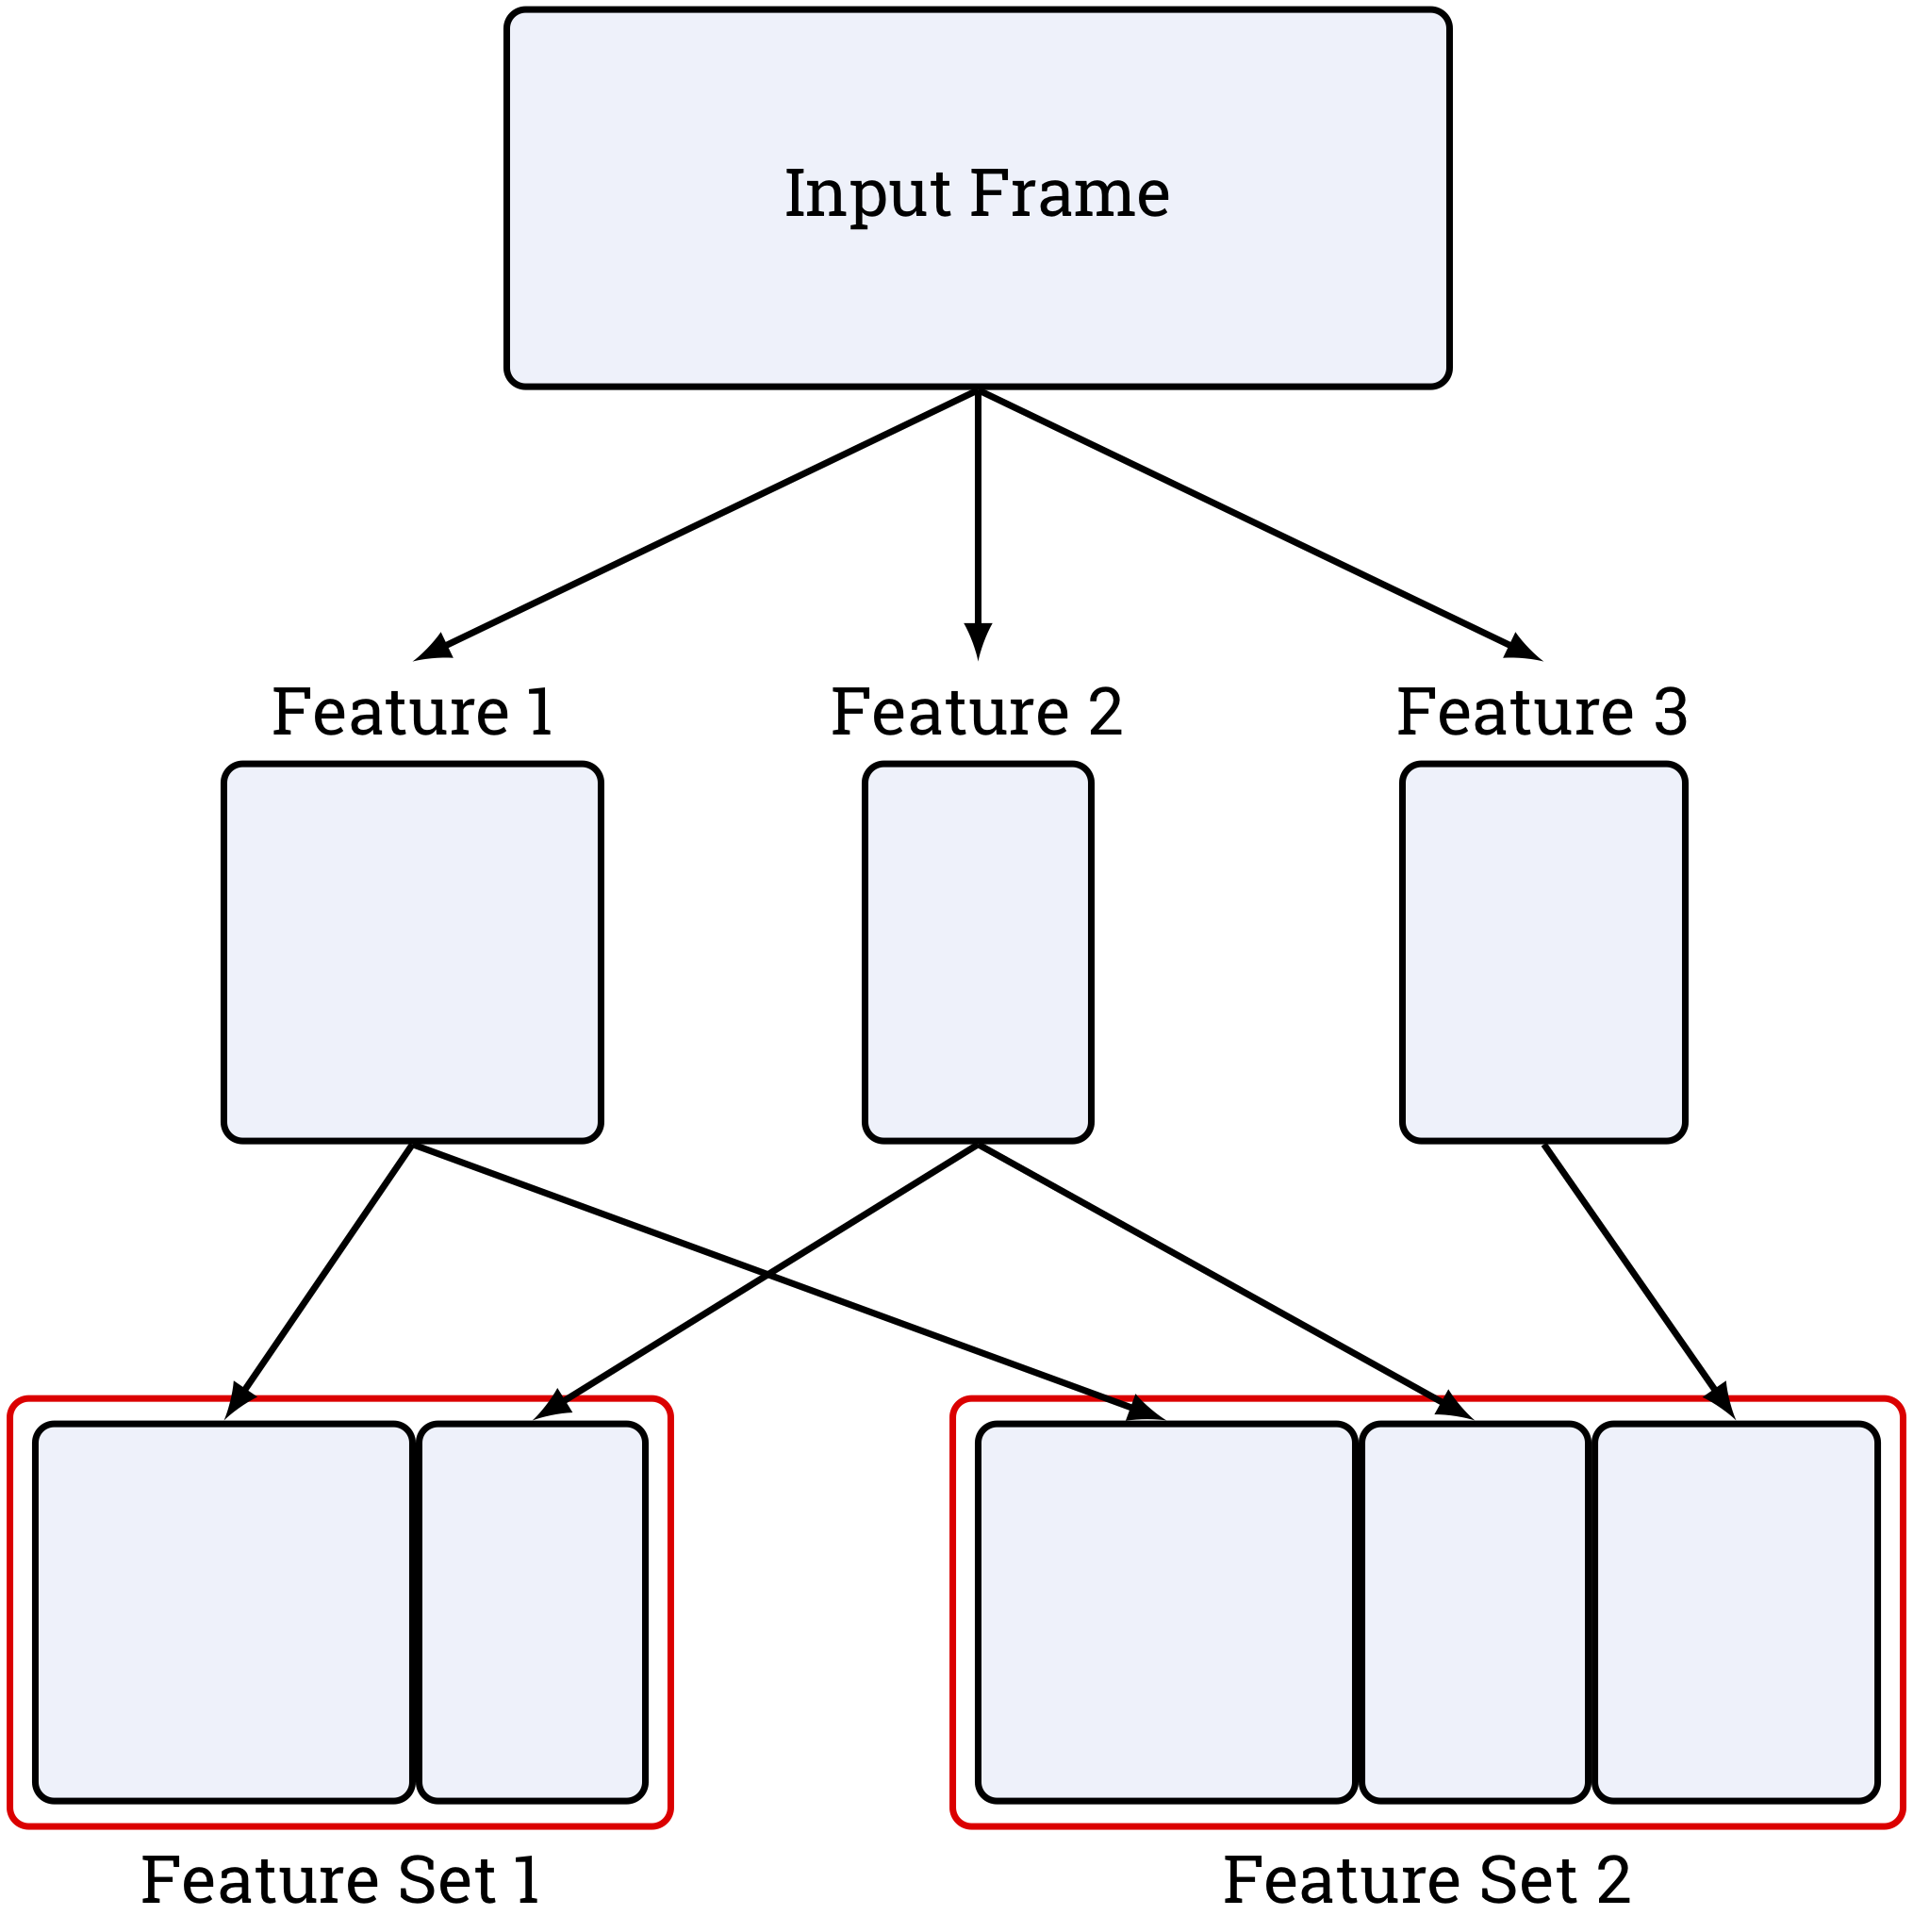

Feature block is defined as a function taking one dataframe as an argument and returning a dataframe, too. Indices of input and output should be identical:

In [6]:
def dummy_feature_a(df):
    res = pd.DataFrame(index=df.index)
    res['a'] = 'a'
    return res

dummy_feature_a(train[:2])
dummy_feature_a(train[2:5])

,a
PassengerId,
1,a
2,a


,a
PassengerId,
3,a
4,a
5,a


`@preview(frame, size_1, size_2, ...)` does almost the same thing as above: it runs your feature constructor on `frame.head(size_1), frame.head(size_2), ...`.


*In addition, you can test out parallel execution. By default all of your features will be parallel, but if you want to change this behavior, use `parallel=False`.*

In [7]:
@preview(train, 2, 5, parallel=True)
def dummy_feature_a(df):
    res = stl.empty_like(df)  # kts.stl is a standard library of feature constructors. Now you need to know
    res['a'] = 'a'            # only that stl.empty_like(df) is identical to pd.DataFrame(index=df.index)
    return res

,a
PassengerId,
1,a
2,a


,a
PassengerId,
1,a
2,a
3,a
4,a
5,a


Feature blocks usually consist of more than one feature:

In [8]:
@preview(train, 3, 6)
def dummy_feature_age_mean(df):
    res = stl.empty_like(df)
    res['Age'] = df['Age']
    res['mean'] = df['Age'].mean()
    return res

,Age,mean
PassengerId,,
1,22.0,28.666667
2,38.0,28.666667
3,26.0,28.666667


,Age,mean
PassengerId,,
1,22.0,31.2
2,38.0,31.2
3,26.0,31.2
4,35.0,31.2
5,35.0,31.2
6,NaN,31.2


Functions are registered and converted into feature constructors using `@feature` decorator:

In [9]:
@feature
def dummy_feature_a(df):
    res = stl.empty_like(df)
    res['a'] = 'a'
    return res

@feature
def dummy_feature_bcd(df):
    res = stl.empty_like(df)
    res['b'] = 'b'
    res['c'] = 'c'
    res['d'] = 'd'
    return res

@feature
def dummy_feature_age_mean(df):
    res = stl.empty_like(df)
    res['mean'] = df['Age'].mean()
    return res

Then a feature set is defined by a list of feature constructors. Use slicing syntax to preview it:

In [10]:
dummy_fs = FeatureSet([dummy_feature_a, dummy_feature_bcd, dummy_feature_age_mean], train_frame=train)
dummy_fs[30:35]

,a,b,c,d,mean
PassengerId,,,,,
31,a,b,c,d,44.666667
32,a,b,c,d,44.666667
33,a,b,c,d,44.666667
34,a,b,c,d,44.666667
35,a,b,c,d,44.666667


Let's clean up our namespace a bit:

In [11]:
delete(dummy_feature_a, force=True)
delete(dummy_feature_bcd, force=True)
delete(dummy_feature_age_mean, force=True)

Now let's get to the real things.  

## Decorators


Almost all of the functions that you'll use have rich docstrings with examples. 
Although it is not necessary, I'll demonstrate them throughout this tutorial.
<!-- Decorators are the most frequently used part of KTS API. Don't be confused by decorators and use cases that you haven't seen yet, as they'll be shown in  -->
Let's first take a closer look at the decorators that you have already seen. 
Don't be confused if you can't understand something, as it will be better explained in the [Feature Types](#Feature-Types) section.

### @preview

In [12]:
preview

<function kts.api.decorators.preview(frame, *sizes, parallel=True, train=True)>

### @feature

In [13]:
feature

<function kts.api.decorators.feature(*args, cache=True, parallel=True, verbose=True)>

### @generic

In [14]:
generic

<function kts.api.decorators.generic(**kwargs)>

### delete

In [15]:
delete

<function kts.api.decorators.delete(feature_or_helper:Union[kts.core.feature_constructor.parallel.ParallelFeatureConstructor, kts.core.feature_constructor.generic.GenericFeatureConstructor, kts.api.helper.Helper], force=False)>

## Feature Types

### Regular Features

This type of FCs should already look quite familiar:

In [16]:
@preview(train, 5)
def simple_feature(df):
    res = stl.empty_like(df)
    res['is_male'] = (df.Sex == 'male') + 0
    return res

,is_male
PassengerId,
1,1
2,0
3,0
4,0
5,1


In [17]:
@feature
def simple_feature(df):
    res = stl.empty_like(df)
    res['is_male'] = (df.Sex == 'male') + 0
    return res

Feature constructors can print anything to stdout and it will be shown in your report in real time, even if your features are computed in separate processes:

In [18]:
@preview(train, 2)
def feature_with_stdout(df):
    res = stl.empty_like(df)
    res['a'] = 'a'
    print('some logs')
    return res

,a
PassengerId,
1,a
2,a


Use `kts.pbar` to track progress of long-running features:

In [19]:
@preview(train, 2)
def feature_with_pbar(df):
    res = stl.empty_like(df)
    res['a'] = 'a'
    for i in pbar(['a', 'b', 'c']):
        time.sleep(1)
    return res

,a
PassengerId,
1,a
2,a


They can also be nested and titled:

In [20]:
@preview(train, 2)
def feature_with_nested_pbar(df):
    res = stl.empty_like(df)
    res['a'] = 'a'
    for i in pbar(['a', 'b', 'c']):
        for j in pbar(range(6), title=i):
            time.sleep(0.5)
    return res

,a
PassengerId,
1,a
2,a


### Features Using External Frames

Sometimes datasets consist of more than one dataframe. To get an external dataframe into you feature constructor's scope, you need to save it with `kts.save()` and then use the following syntax:

In [21]:
external = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
kts.save(external, 'external')

@preview(train, 7)
def feature_using_external(df, somename='external'):
    """
    To get an external dataframe, you should set its name in user cache as a default value.
    Inside it will look like a usual dataframe.
    """
    print(somename.__class__.__name__)
    time.sleep(1)  # a short delay to receive stdout
    res = stl.empty_like(df)
    res['Pclass'] = df['Pclass']
    res['somefeat'] = somename.set_index('a').loc[df['Pclass']]['b'].values
    return res

,Pclass,somefeat
PassengerId,,
1,3,6
2,1,4
3,3,6
4,1,4
5,3,6
6,3,6
7,1,4


### Stateful Features

Some features may need their state to be saved between training and inference stages. In this case you can use `df.train` or `df._train` to identify which stage it is and `df.state` or `df._state` as a dictionary to write and read the state:

*Unfortunately, so far you can preview only training stage using @preview. Later we'll add @preview_train_test to emulate both stages.*

In [22]:
@preview(train, 5)
def stateful_feature(df):
    """A simple standardizer"""
    res = stl.empty_like(df)
    if df.train:
        print('this is a training stage')
        df.state['mean'] = df['Age'].mean()
        df.state['std'] = df['Age'].std()
    mean = df.state['mean']
    std = df.state['mean']
    res['Age'] = df['Age']
    res['age_std'] = (df['Age'] - mean) / std
    return res

,Age,age_std
PassengerId,,
1,22.0,-0.294872
2,38.0,0.217949
3,26.0,-0.166667
4,35.0,0.121795
5,35.0,0.121795


### Generic Features

You can also create reusable functions with `@generic(arg1=default, arg2=default, ...)`. For preview, default arguments are used.

In [23]:
@preview(train, 5)
@generic(left="Pclass", right="SibSp")
def interactions(df):
    res = stl.empty_like(df)
    res[f"{left}_add_{right}"] = df[left] + df[right]
    res[f"{left}_sub_{right}"] = df[left] - df[right]
    res[f"{left}_mul_{right}"] = df[left] * df[right]
    return res

,Pclass_add_SibSp,Pclass_sub_SibSp,Pclass_mul_SibSp
PassengerId,,,
1,4,2,3
2,2,0,1
3,3,3,0
4,2,0,1
5,3,3,0


Let's register a couple of generic features:

In [24]:
@feature
@generic(left="Pclass", right="SibSp")
def interactions(df):
    res = stl.empty_like(df)
    res[f"{left}_add_{right}"] = df[left] + df[right]
    res[f"{left}_sub_{right}"] = df[left] - df[right]
    res[f"{left}_mul_{right}"] = df[left] * df[right]
    return res

In [25]:
@feature
@generic(col="Parch")
def num_aggs(df):
    """Descriptions are also supported."""
    res = pd.DataFrame(index=df.index)
    mean = df[col].mean()
    std = df[col].std()
    res[f"{col}_div_mean"] = df[col] / mean
    res[f"{col}_sub_div_mean"] = (df[col] - mean) / mean
    res[f"{col}_div_std"] = df[col] / std
    return res

A combination of generic and stateful feature. It also returns a numpy array instead of dataframe. In this case, KTS will attach input index to result dataframe automatically.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

@preview(train, 10)
@generic(col='Name')
def tfidf(df):
    if df.train:
        enc = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_features=5)
        res = enc.fit_transform(df[col])
        df.state['enc'] = enc
    else:
        enc = df.state['enc']
        res = enc.transform(df[col])
    return res.todense()

,tfidf__Name_0,tfidf__Name_1,tfidf__Name_2,tfidf__Name_3,tfidf__Name_4
PassengerId,,,,,
1,0.508281,0.338854,0.185575,0.742300,0.203426
2,0.593616,0.197872,0.433463,0.541828,0.356369
3,0.464173,0.464173,0.508413,0.000000,0.557318
4,0.603771,0.301886,0.661317,0.220439,0.241644
5,0.631088,0.420725,0.460825,0.460825,0.000000
6,0.508984,0.508984,0.278748,0.557496,0.305561
7,0.779844,0.259948,0.000000,0.569447,0.000000
8,0.395067,0.526756,0.288481,0.288481,0.632461
9,0.605911,0.302956,0.442440,0.331830,0.485000


Don't forget to change `@preview` to `@feature` to register generics:

In [27]:
@feature
@generic(col='Name')
def tfidf(df):
    if df.train:
        enc = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_features=5)
        res = enc.fit_transform(df[col])
        df.state['enc'] = enc
    else:
        enc = df.state['enc']
        res = enc.transform(df[col])
    return res.todense()

Note that KTS added sklearn to dependencies. Right now it is not very useful, but later it may be used to dockerize experiments automatically.

## Standard Library

KTS provides the most essential feature constructors as a standard library, i.e. `kts.stl` submodule. All of the STL features have rich docstrings.

### stl.empty_like

In [28]:
stl.empty_like

stl.empty_like

In [29]:
@preview(train, 5)
def preview_stl(df):
    return stl.empty_like(df)

""
PassengerId
1
2
3
4
5


### stl.identity

In [30]:
stl.identity

stl.identity

In [31]:
@preview(train, 5)
def preview_stl(df):
    return stl.identity(df)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### stl.select

In [32]:
stl.select

<function kts.stl.api.select(columns:List[str]) -> kts.core.feature_constructor.base.Selector>

In [33]:
@preview(train, 5)
def preview_stl(df):
    return stl.select(['Name', 'Sex'])(df)

,Name,Sex
PassengerId,,
1,"Braund, Mr. Owen Harris",male
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female
3,"Heikkinen, Miss. Laina",female
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female
5,"Allen, Mr. William Henry",male


### stl.drop

In [34]:
stl.drop

<function kts.stl.api.drop(columns:List[str]) -> kts.core.feature_constructor.base.Dropper>

In [35]:
@preview(train, 5)
def preview_stl(df):
    return stl.drop(['Survived'])(df)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### stl.concat

In [36]:
stl.concat

<function kts.stl.api.concat(feature_constructors:List[kts.core.feature_constructor.base.BaseFeatureConstructor]) -> kts.stl.backend.Concat>

In [37]:
@preview(train, 5)
def preview_stl(df):
    res = stl.concat([
        stl.select(['Sex', 'Name']),
        simple_feature,
        tfidf('Name')
    ])(df)
    return res

,Name,Sex,is_male,tfidf__Name_0,tfidf__Name_1,tfidf__Name_2,tfidf__Name_3,tfidf__Name_4
PassengerId,,,,,,,,
1,"Braund, Mr. Owen Harris",male,1,0.497477,0.331651,0.165826,0.000000,0.784236
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0,0.610662,0.203554,0.407108,0.240666,0.601665
3,"Heikkinen, Miss. Laina",female,0,0.546402,0.546402,0.546402,0.323011,0.000000
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0,0.544245,0.272122,0.544245,0.536227,0.214491
5,"Allen, Mr. William Henry",male,1,0.447424,0.298283,0.298283,0.705332,0.352666


### stl.apply

In [38]:
stl.apply

<function kts.stl.api.apply(df:pandas.core.frame.DataFrame, func:Callable, parts:Union[int, NoneType]=None, optimize:bool=True, verbose:bool=False) -> pandas.core.frame.DataFrame>

In [52]:
@preview(train, 700, parallel=True)
def preview_stl(df):
    def func(row):
        """A regular row-wise function with any logic."""
        time.sleep(0.1)
        if row.Embarked == 'S':
            return row.SibSp
        return row.Age
    res = stl.empty_like(df)
    res['col'] = stl.apply(df, func, parts=7, verbose=True)
    return res

,col
PassengerId,
1,1.0
2,38.0
3,0.0
4,1.0
5,0.0
...,...
696,0.0
697,0.0
698,NaN


### stl.category_encode

In [40]:
stl.category_encode

<function kts.stl.api.category_encode(encoder, columns:Union[List[str], str], targets:Union[List[str], str, NoneType]=None) -> kts.stl.backend.CategoryEncoder>

In [41]:
from category_encoders import CatBoostEncoder, WOEEncoder, TargetEncoder

@preview(train, 100)
def preview_stl(df):
    encoder = CatBoostEncoder(sigma=3)
    return stl.category_encode(encoder, columns=['Cabin', 'Embarked'], targets='Survived')(df)

,Cabin_ce_Survived_CatBoostEncoder_sigma_3,Embarked_ce_Survived_CatBoostEncoder_sigma_3
PassengerId,,
1,-0.091375,-0.692933
2,1.132605,-1.181186
3,-0.860142,0.126885
4,0.419249,1.716995
5,1.383037,-1.836323
...,...,...
96,0.150710,-1.729577
97,0.337683,2.954273
98,-0.566066,2.601976


In [42]:
@preview(train, 100)
def preview_stl(df):
    return stl.concat([
        stl.select(['Cabin', 'Survived']),
        stl.category_encode(CatBoostEncoder(), columns='Cabin', targets='Survived'),
        stl.category_encode(WOEEncoder(), columns='Cabin', targets='Survived'),
        stl.category_encode(TargetEncoder(), columns='Cabin', targets='Survived'),
    ])(df)

,Survived,Cabin,Cabin_ce_Survived_CatBoostEncoder,Cabin_ce_Survived_WOEEncoder,Cabin_ce_Survived_TargetEncoder
PassengerId,,,,,
1,0,NaN,0.410000,-0.253322,0.35
2,1,C85,0.410000,0.000000,0.41
3,1,NaN,0.205000,-0.253322,0.35
4,1,C123,0.410000,0.000000,0.41
5,0,NaN,0.470000,-0.253322,0.35
...,...,...,...,...,...
96,0,NaN,0.351410,-0.253322,0.35
97,0,A5,0.410000,0.000000,0.41
98,1,D10 D12,0.410000,0.000000,0.41


### stl.mean_encode

In [43]:
stl.mean_encode

<function kts.stl.api.mean_encode(columns:Union[List[str], str], targets:Union[List[str], str], smoothing:float=1.0, min_samples_leaf:int=1) -> kts.stl.backend.CategoryEncoder>

In [44]:
@preview(train, 100)
def preview_stl(df):
    """An alias for stl.category_encode(TargetEncoder())"""
    return stl.mean_encode('Cabin', 'Survived', smoothing=3)(df)

,Cabin_ce_Survived_TargetEncoder_smoothing_3.0
PassengerId,
1,0.35
2,0.41
3,0.35
4,0.41
5,0.35
...,...
96,0.35
97,0.41
98,0.41


### stl.one_hot_encode

In [45]:
stl.one_hot_encode

<function kts.stl.api.one_hot_encode(columns:Union[List[str], str]) -> kts.stl.backend.CategoryEncoder>

In [46]:
@preview(train, 100, parallel=False)  # One hot encoder produces a lot of columns, but is computationally cheap, that's why we don't compute it in parallel
def preview_stl(df):
    """An alias for stl.category_encode(OneHotEncoder())"""
    return stl.one_hot_encode('Embarked')(df)

,Embarked_ce_OneHotEncoder_0,Embarked_ce_OneHotEncoder_1,Embarked_ce_OneHotEncoder_2,Embarked_ce_OneHotEncoder_3
PassengerId,,,,
1,1,0,0,0
2,0,1,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
...,...,...,...,...
96,1,0,0,0
97,0,1,0,0
98,0,1,0,0


## Feature Set

In [47]:
FeatureSet

kts.core.feature_set.FeatureSet

In [48]:
fs = FeatureSet([simple_feature, interactions('Pclass', 'Age'), num_aggs('Fare'), tfidf('Name')], 
                [stl.category_encode(TargetEncoder(), 'Embarked', 'Survived'), 
                 stl.category_encode(WOEEncoder(), 'Embarked', 'Survived')],
                train_frame=train,
                targets='Survived')

Each feature set is given a unique identifier. It also contains source code of all the features right in its repr:

In [50]:
fs

Use slicing to preview your feature sets. Slicing calls are not cached and do not leak dataframes to IPython namespace, so you can run them as many times as you need. For stateful features, slicing calls always trigger a training stage.

In [51]:
fs[:10]

,is_male,Pclass_add_Age,Pclass_sub_Age,Pclass_mul_Age,Fare_div_mean,Fare_sub_div_mean,Fare_div_std,tfidf__Name_0,tfidf__Name_1,tfidf__Name_2,tfidf__Name_3,tfidf__Name_4,Embarked_ce_Survived_TargetEncoder,Embarked_ce_Survived_WOEEncoder
PassengerId,,,,,,,,,,,,,,
1,1,25.0,-19.0,66.0,0.268312,-0.731688,0.307178,0.508281,0.338854,0.185575,0.742300,0.203426,0.428748,-0.223144
2,0,39.0,-37.0,38.0,2.638088,1.638088,3.020231,0.593616,0.197872,0.433463,0.541828,0.356369,0.865529,1.098612
3,0,29.0,-23.0,78.0,0.293292,-0.706708,0.335778,0.464173,0.464173,0.508413,0.000000,0.557318,0.428748,-0.223144
4,0,36.0,-34.0,35.0,1.965151,0.965151,2.249815,0.603771,0.301886,0.661317,0.220439,0.241644,0.428748,-0.223144
5,1,38.0,-32.0,105.0,0.297918,-0.702082,0.341074,0.631088,0.420725,0.460825,0.460825,0.000000,0.428748,-0.223144
6,1,NaN,NaN,NaN,0.313029,-0.686971,0.358373,0.508984,0.508984,0.278748,0.557496,0.305561,0.500000,0.000000
7,1,55.0,-53.0,54.0,1.919353,0.919353,2.197383,0.779844,0.259948,0.000000,0.569447,0.000000,0.428748,-0.223144
8,1,5.0,1.0,6.0,0.779954,-0.220046,0.892935,0.395067,0.526756,0.288481,0.288481,0.632461,0.428748,-0.223144
9,0,30.0,-24.0,81.0,0.412027,-0.587973,0.471711,0.605911,0.302956,0.442440,0.331830,0.485000,0.428748,-0.223144
